<a href="https://colab.research.google.com/github/sergioanez/FIV-Harvesting/blob/main/FIV_force_prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FIV force prediction neural network with 30 evenly spaced sensors (5x6)

input: features, labels
 - features = flow field at specific points (sensors) 
 - labels = known forces (lift and drag)

output: predicted forces (lift and drag)

----



In [ ]:
# sensor locations:

# evenly spaced 6x5 grid 
x_sensors = 6
y_sensors = 5
num_sensors = x_sensors * y_sensors

### Importing reduced data
we pre selected data at 30 sensor locations (5x6 grid) in MATLAB


In [ ]:
pip install mat73

In [ ]:
import scipy.io as spio
import mat73

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Colab\ Notebooks/FIV\ force\ prediction/reduced_files.zip

Archive:  gdrive/My Drive/Colab Notebooks/FIV force prediction/reduced_files.zip
  inflating: uStar10_50/configuration.mat  
  inflating: uStar10_50/positionVelocity.mat  
  inflating: uStar10_50/reducedField_5_6.mat  
  inflating: uStar3_75/configuration.mat  
  inflating: uStar3_75/positionVelocity.mat  
  inflating: uStar3_75/reducedField_5_6.mat  
  inflating: uStar4_50/configuration.mat  
  inflating: uStar4_50/positionVelocity.mat  
  inflating: uStar4_50/reducedField_5_6.mat  
  inflating: uStar5_50/configuration.mat  
  inflating: uStar5_50/positionVelocity.mat  
  inflating: uStar5_50/reducedField_5_6.mat  
  inflating: uStar5_75/configuration.mat  
  inflating: uStar5_75/positionVelocity.mat  
  inflating: uStar5_75/reducedField_5_6.mat  
  inflating: uStar6_50/configuration.mat  
  inflating: uStar6_50/positionVelocity.mat  
  inflating: uStar6_50/reducedField_5_6.mat  
  inflating: uStar7_50/configuration.mat  
  inflating: uStar7_50/positionVelocity.mat  
  inflating: uSta

### putting data in dataframe

In [ ]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import IPython
import IPython.display
from scipy import interpolate
from scipy.interpolate import interp1d
from sklearn import linear_model


# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
uStars = ["uStar3_75", "uStar4_50", "uStar5_50", "uStar5_75",
          "uStar6_50", "uStar7_50", "uStar8_00", "uStar8_25",
          "uStar8_75", "uStar9_00", "uStar9_25", "uStar10_50"]

In [ ]:
dataset = pd.DataFrame()

for uStar in uStars:

  # organize data
  posVel = mat73.loadmat(uStar + '/positionVelocity.mat')
  reducedField_5_6 = spio.loadmat(uStar + '/reducedField_5_6.mat', squeeze_me=True)
  reducedField_5_6 = reducedField_5_6['reducedField']
  config = spio.loadmat(uStar + '/configuration.mat', squeeze_me=True)

  xIndices = np.linspace(0,config['numX']-1,x_sensors).astype(int)
  yIndices = np.linspace(0,config['numY']-1,y_sensors).astype(int) 
  x = config["X"][0,xIndices]
  y = config["Y"][yIndices,0]

  numT = config['numT']
  time_steps = np.arange(numT)

  # add x, y, time steps
  a = [y,x,time_steps]
  data = list(itertools.product(*a))
  df = pd.DataFrame(data=data, columns=["y", "x", "t"])

  # add u and v
  df['u'] = reducedField_5_6[:,:,:,0].flatten()
  df['v'] = reducedField_5_6[:,:,:,1].flatten()

  # add cylinder properties (lift, drag, pos, vel)
  df['lift'] = np.tile(posVel['lift'], x_sensors*y_sensors)
  df['drag'] = np.tile(posVel['drag'], x_sensors*y_sensors)
  df['pos'] = np.tile(posVel['position'], x_sensors*y_sensors)
  df['vel'] = np.tile(posVel['velocity'], x_sensors*y_sensors)

  # add uStar
  uStar_float = uStar[5:]
  uStar_float = uStar_float.replace('_', '.')
  uStar_float = float(uStar_float)
  df['uStar'] = uStar_float

  dataset = dataset.append(df)
  
dataset.reset_index(inplace=True, drop=True)


In [ ]:
dataset

,y,x,t,u,v,lift,drag,pos,vel,uStar
0,51.443524,-14.110060,0,0.221441,0.004109,0.040710,-0.224721,0.000386,-0.021276,3.75
1,51.443524,-14.110060,1,0.221361,0.001884,-0.074137,-0.290276,-0.000382,-0.015700,3.75
2,51.443524,-14.110060,2,0.220746,0.004701,-0.285623,-0.255234,-0.000912,-0.010408,3.75
3,51.443524,-14.110060,3,0.223347,0.004990,-0.243094,-0.286218,-0.001194,-0.000195,3.75
4,51.443524,-14.110060,4,0.224962,0.008288,-0.244433,-0.279614,-0.000909,0.011848,3.75
...,...,...,...,...,...,...,...,...,...,...
1859125,-71.263671,120.517263,4762,0.233773,-0.011184,-0.062120,-0.240097,0.000013,-0.001910,10.50
1859126,-71.263671,120.517263,4763,0.227725,-0.019083,0.034420,-0.294296,-0.000166,-0.004246,10.50
1859127,-71.263671,120.517263,4764,0.224331,-0.018188,-0.123794,-0.240556,-0.000324,-0.003534,10.50
1859128,-71.263671,120.517263,4765,0.222699,-0.016903,0.037499,-0.269412,-0.000569,-0.006935,10.50


### Looking at specific uStar

In [ ]:
uStar = 7.50

In [ ]:
dataset_10_50 = dataset[dataset['uStar'] == uStar]
dataset_10_50 = dataset_10_50.sort_values(by=['t'])
dataset_10_50 = dataset_10_50.drop(columns=['y', 'x', 'pos', 'vel', 'uStar'])

In [ ]:
# looking at the data
dataset_10_50.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t,143010.0,2383.000000,1376.119148,0.000000,1191.000000,2383.000000,3575.000000,4766.000000
u,143010.0,0.202347,0.053005,-0.220987,0.196301,0.217288,0.228605,0.370917
v,143010.0,-0.001273,0.048695,-0.328527,-0.016561,-0.000367,0.015538,0.262340
lift,143010.0,0.000258,0.157036,-0.296510,-0.151091,0.004898,0.144848,0.331448
drag,143010.0,-0.294863,0.041901,-0.416789,-0.326961,-0.296822,-0.261401,-0.181166


In [ ]:
# reshaping

dataset_10_50['idx'] = dataset_10_50.groupby('t').cumcount()
dataset_10_50.pivot(index='t',columns='idx')[['u','v']]

dataset_10_50['u_idx'] = 'u_' + dataset_10_50.idx.astype(str)
dataset_10_50['v_idx'] = 'v_' + dataset_10_50.idx.astype(str)

u = dataset_10_50.pivot(index='t',columns='u_idx', values='u')
v = dataset_10_50.pivot(index='t',columns='v_idx', values='v')

dataset_10_50_wide = pd.concat([u,v],axis=1)
dataset_10_50_wide['lift'] = dataset_10_50.set_index('t')['lift'].drop_duplicates()
dataset_10_50_wide['drag'] = dataset_10_50.set_index('t')['drag'].drop_duplicates()
dataset_10_50_wide

,u_0,u_1,u_10,u_11,u_12,u_13,u_14,u_15,u_16,u_17,u_18,u_19,u_2,u_20,u_21,u_22,u_23,u_24,u_25,u_26,u_27,u_28,u_29,u_3,u_4,u_5,u_6,u_7,u_8,u_9,v_0,v_1,v_10,v_11,v_12,v_13,v_14,v_15,v_16,v_17,v_18,v_19,v_2,v_20,v_21,v_22,v_23,v_24,v_25,v_26,v_27,v_28,v_29,v_3,v_4,v_5,v_6,v_7,v_8,v_9,lift,drag
t,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.224310,0.209753,0.167814,0.171944,0.218746,0.231006,0.282251,-0.003779,0.205268,0.138548,0.283473,0.208838,0.223732,0.197488,0.220734,0.253317,0.236601,0.190659,0.234293,0.212142,0.221308,0.221532,0.234153,0.226838,0.269535,0.174195,0.231849,0.213589,0.232589,0.159493,0.004723,0.020523,0.087344,-0.093228,-0.001106,-0.031455,-0.137769,0.098895,-0.034313,0.000203,0.062454,0.000200,0.035672,-0.015380,-0.030145,0.002315,-0.004417,-0.026849,-0.003128,0.006185,0.008158,-0.008814,0.028929,-0.010060,0.037690,-0.028794,-0.001080,-0.076628,0.000485,-0.048142,0.040283,-0.299843
1,0.215829,0.214798,0.193017,0.275807,0.221866,0.230039,0.227209,0.222657,0.234123,0.259140,0.209509,0.203949,0.218004,0.204183,0.227861,0.228716,0.155708,-0.025790,0.236051,0.129241,0.221795,0.191669,0.221381,0.233833,0.208037,0.213192,0.242052,0.215725,0.231283,0.217687,0.030633,0.112625,-0.047780,0.036122,-0.020866,-0.000234,-0.030931,-0.009730,0.037005,0.007453,0.026892,-0.025981,-0.008908,-0.038506,0.006677,0.007242,0.006122,0.076940,-0.000054,0.103953,-0.084584,-0.136921,-0.003996,-0.005389,-0.064266,0.001690,-0.001568,0.006744,-0.000297,-0.033627,0.168645,-0.229706
2,0.231891,0.177351,0.245875,0.261157,0.214098,0.211611,0.228698,0.232468,0.233364,0.158619,0.169540,0.193401,0.199011,0.233069,0.209706,0.214120,0.006898,0.221154,0.217120,0.147784,0.197566,0.204693,0.212380,0.126865,0.231081,0.207462,0.231075,0.224275,0.217652,0.254975,-0.000057,-0.003729,0.041093,0.014016,-0.003805,0.031240,0.004889,-0.032496,0.003860,0.040429,0.148666,-0.054770,-0.028471,-0.012827,0.018081,-0.013369,0.040503,0.006205,-0.007574,0.098973,-0.059502,-0.003191,-0.123473,0.009342,-0.129538,-0.006787,-0.007297,-0.003828,-0.012270,0.008096,0.154994,-0.240834
3,0.177813,0.161497,0.224980,0.215166,0.179411,0.191899,0.192510,0.038717,0.237979,0.162420,0.091683,0.213724,0.126677,0.203307,0.184208,0.224855,0.257629,0.235102,0.219343,0.232729,0.210639,0.228541,0.216687,0.236286,0.215181,0.224230,0.260774,0.322561,0.209954,0.233197,-0.025695,0.065579,-0.006123,-0.008087,-0.059463,0.094835,0.015053,-0.021350,-0.034433,-0.098274,0.081245,-0.004897,-0.035256,-0.029187,-0.006214,0.007373,-0.105972,0.063527,0.036165,-0.009601,0.011943,0.007197,0.001266,0.001364,-0.002281,-0.018268,0.021662,0.016828,0.005118,0.000530,0.277487,-0.266792
4,0.117835,0.149524,0.215912,0.238240,0.244577,0.228278,0.234074,0.155101,0.218341,0.237050,0.226038,0.148400,0.047036,0.202651,0.096823,0.217906,0.206761,0.217372,0.212412,0.260726,0.195655,0.227372,0.229549,0.235678,0.205384,0.219079,0.208487,0.249252,0.201230,0.150640,0.129312,0.091791,-0.005906,-0.038320,-0.036354,0.007859,-0.013885,-0.162515,0.006703,-0.008470,-0.004646,-0.046372,-0.021528,0.049851,-0.007493,-0.004382,0.024140,-0.005567,0.001885,0.027899,-0.014242,0.040925,0.008678,-0.000578,0.021403,-0.017115,-0.028987,0.028255,0.049681,-0.059425,0.155012,-0.245786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4762,0.212527,0.212564,0.209689,0.145584,0.205160,0.226478,0.224312,0.236179,0.211447,0.210991,0.237251,0.195998,0.215189,0.034992,0.137297,0.223321,0.000000,0.177171,0.158929,0.205090,0.225561,0.192014,0.229066,0.211375,0.232097,0.216811,0.224720,0.225948,0.254304,0.246004,0.001701,-0.013152,0.026418,-0.033232,-0.033339,0.005686,-0.070896,0.023781,-0.073144,0.006677,-0.000502,-0.031840,-0.007246,-0.044792,0.131748,-0.075396,0.000000,0.113651,0.055977,0.062552,0.013635,0.035985,0.039994,-0.002790,-0

In [ ]:
#rename df
df = dataset_10_50_wide.copy()

#DROP DRAG TEMPORARILY
df = df.drop(columns=['drag'])

In [ ]:
# split the data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.5)]
val_df = df[int(n*0.5):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
# normalize the data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

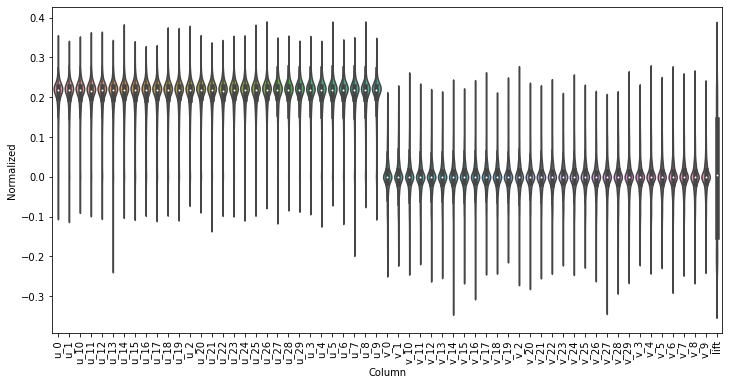

In [ ]:
# looking at the normalization:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Data windowing

In [ ]:
# defining prediction window

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # all column indices
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}

    # Work out the non-label column indices.
    self.all_columns = list(train_df.columns)    
    self.non_label_columns = [x for x in self.all_columns if x not in label_columns] 
    if self.non_label_columns is not None:
      self.non_label_columns_indices = {name: i for i, name in
                                    enumerate(self.non_label_columns)}   

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
# splitting window into a window of inputs and a window of labels

def split_window(self, features):

  inputs = features[:, self.input_slice, :]
  if self.label_columns is not None:
    inputs = tf.stack(
        [inputs[:, :, self.column_indices[name]] for name in self.non_label_columns],
        axis=-1)

  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# creating TensorFlow datasets

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=24,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
# Add properties for accessing tf.data.Datasets. Also, add a standard example batches for easy access and plotting:

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

@property
def val_example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_val_example', None)
  if result is None:
    # No example batch was found, so get one from the `validation` dataset
    result = next(iter(self.val))
    # And cache it for next time
    self._val_example = result
  return result


@property
def test_example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_test_example', None)
  if result is None:
    # No example batch was found, so get one from the `test` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._test_example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.val_example = val_example
WindowGenerator.test_example = test_example

# LSTM model

In [ ]:
# Choosing our paramaters for our network

def compile_and_fit(model, window, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  # learning rate scheduler
  #def scheduler(epoch, lr, val_loss):
  #  if epoch < 5:
  #    return lr
  #  else:
  #    return lr * tf.math.exp(-0.1)
  #lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

 # initial_learning_rate = 0.1
 # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
 #  initial_learning_rate,
 #  decay_steps=100000,
 #  decay_rate=0.96,
 #  staircase=True)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.RootMeanSquaredError()])
  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val)
                      #callbacks=[early_stopping])
  return history

In [ ]:
wide_window = WindowGenerator(
    input_width=32, label_width=32, shift=1,
    label_columns=['lift'])

wide_window

Total window size: 33
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Label column name(s): ['lift']

In [1]:
MAX_EPOCHS = 60
neurons_per_layer = 128

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(neurons_per_layer, activation='relu', return_sequences=True),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dropout(0.05, seed=None),
    tf.keras.layers.LSTM(neurons_per_layer, activation='relu', return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

NameError: ignored

In [ ]:
history = compile_and_fit(lstm_model, wide_window)


Epoch 1/60
98/98 [==============================] - 12s 92ms/step - loss: 0.9938 - mean_absolute_error: 0.8750 - root_mean_squared_error: 0.9969 - val_loss: 0.9585 - val_mean_absolute_error: 0.8593 - val_root_mean_squared_error: 0.9790
Epoch 2/60
98/98 [==============================] - 9s 87ms/step - loss: 0.9132 - mean_absolute_error: 0.8343 - root_mean_squared_error: 0.9556 - val_loss: 0.8470 - val_mean_absolute_error: 0.7976 - val_root_mean_squared_error: 0.9203
Epoch 3/60
98/98 [==============================] - 8s 86ms/step - loss: 0.7249 - mean_absolute_error: 0.7296 - root_mean_squared_error: 0.8514 - val_loss: 0.7340 - val_mean_absolute_error: 0.7177 - val_root_mean_squared_error: 0.8567
Epoch 4/60
98/98 [==============================] - 8s 85ms/step - loss: 0.5710 - mean_absolute_error: 0.6321 - root_mean_squared_error: 0.7557 - val_loss: 0.6427 - val_mean_absolute_error: 0.6659 - val_root_mean_squared_error: 0.8017
Epoch 5/60
98/98 [==============================] - 8s 86ms

In [ ]:
def plot_over_time(self, model=None, plot_col=None, example_type=None):
  '''
  plot_col: 'lift' or 'drag'
  example_type:
        'train': training example
        'val': validation example
        'test': test example
  '''
  if example_type == 'train':
    example = self.example
  if example_type == 'val':
    example = self.val_example
  if example_type == 'test':
    example = self.test_example

  inputs, labels = example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]

  #for spline
  x_label = []
  y_label = []
  x_pred = []
  y_pred = []

  max_n = len(inputs)
  for n in range(max_n):
    plt.ylabel(f'{plot_col} [normed]')
    #plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             #label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    # changing x axis to seconds  
    x_sec = ((self.label_indices+n)+1)/24


    # plotting labels
    labels_unnormalized = labels * train_std[label_col_index] + train_mean[label_col_index]
    if n == 0:
      label = 'Labels'
    else:
      label = '_nolegend_'
    plt.scatter(x_sec, labels[n, :, label_col_index],
                edgecolors='k', label=label, c='#2ca02c', s=64)

    #plotting predictions
    if model is not None:
      predictions = model(inputs)
      predictions_unnormalized = predictions * train_std[label_col_index] + train_mean[label_col_index]
      if n == 0:
        label = 'Predictions'
      else:
        label = '_nolegend_'
      plt.scatter(x_sec, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label=label,
                  c='#ff7f0e', s=64)
 
  
    #for spline
    x_label.append(float(x_sec))
    y_label.append(float(labels[n, :, label_col_index]))
    x_pred.append(float(x_sec))
    y_pred.append(float(predictions[n, :, label_col_index]))

    if n == 0:
      plt.legend()

  #spline fit
  f_label = interp1d(x_label, y_label, kind='cubic')
  xnew = np.linspace(x_label[0], x_label[-1], num=len(x_label)*10)
  plt.plot(xnew, f_label(xnew), '-')

  f_pred = interp1d(x_pred, y_pred, kind='cubic')
  plt.plot(xnew, f_pred(xnew), '-')




  plt.title('Ustar = ' + str(uStar) + '\nEpochs: ' + str(MAX_EPOCHS)
            + '\nneurons/layer: ' + str(neurons_per_layer))
  plt.xlabel('Time (s)')

WindowGenerator.plot_over_time = plot_over_time

In [ ]:
def plot(self, model=None, plot_col='drag', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
#wide_window.plot(lstm_model)
wide_window.plot_over_time(lstm_model, plot_col='drag', example_type='test')

KeyError: ignored

<Figure size 864x576 with 0 Axes>

Plotting loss vs epochs

In [ ]:
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

37/37 [==============================] - 1s 14ms/step - loss: 0.7173 - mean_absolute_error: 0.7025 - root_mean_squared_error: 0.8469


In [ ]:
performance

{'LSTM': [0.6007121205329895, 0.6248243451118469, 0.7750561833381653]}

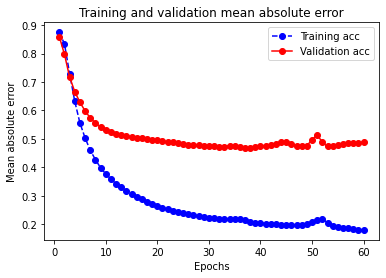

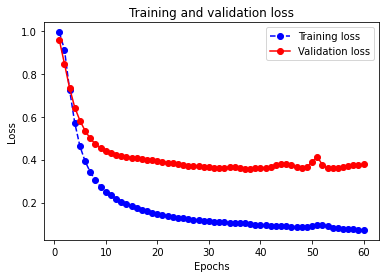

In [ ]:
# Plotting our accuracy and loss functions

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, mae, 'bo--', label='Training acc')
plt.plot(epochs, val_mae, 'ro-', label='Validation acc')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('Mean absolute error')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo--', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Looking at average final loss values

In [ ]:
avg_train_loss = np.mean(loss[15:20]) # avg training loss (last 5 epochs)
avg_val_loss = np.mean(val_loss[15:20]) # avg validation loss (last 5 epochs)

print(avg_train_loss)
print(avg_val_loss)

nan
nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
